# Exploring featurization

The material in this notebook will be pushed into the slides as follows:
- First example (abalone) quadratic and quantile features don't improve performance.
    - Ask people to theorize why.
    - If the conditional expectation function is truly linear, then extra features won't help.
    - Show joint density plots to give some hand-waving evidence.
- Second example we do get a performance bump. Note the sample size is small so it's not particularly robust.


In [274]:
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin
from sklearn.preprocessing import QuantileTransformer,OneHotEncoder,LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [275]:
# First example the performance doesn't change

In [276]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',
                 header=None)

In [277]:
df.shape

(4177, 9)

In [278]:
df = df.rename(columns={
    0:'sex',
    1:'length',
    2:'diameter',
    3:'height',
    4:'whole_weight',
    5:'shucked_weight',
    6:'viscera_weight',
    7:'shell_weight',
    8:'rings'
})

In [290]:
categorical = ['sex']

numeric = ['length', 'diameter', 'height',
        'whole_weight', 'shucked_weight',
        'shell_weight']

In [291]:
class OneHotStrings(TransformerMixin):
    
    def __init__(self):    
        self.labeler = LabelEncoder()
        self.enc = OneHotEncoder()
        
    def fit(self,X):
        self.labeler.fit(X)
        _X = self.labeler.transform(X).reshape(-1,1)
        self.enc.fit(_X)
        return X
    
    def transform(self,X):
        _X = self.labeler.transform(X).reshape(-1,1)
        return self.enc.transform(_X)

In [292]:
mapper = DataFrameMapper(
    [(col, None) for col in numeric] + \
    [([col], QuantileTransformer(n_quantiles=10)) for col in numeric] + \
    [(col, OneHotStrings()) for col in categorical])

In [293]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[('length', None), ('diameter', None), ('height', None), ('whole_weight', None), ('shucked_weight', None), ('shell_weight', None), (['length'], QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=10,
          output_distribution='uniform', random_state=None,
          s..._state=None,
          subsample=100000)), ('sex', <__main__.OneHotStrings object at 0x1a22066160>)],
        input_df=False, sparse=False)

In [294]:
train_X, test_X, train_y, test_y = train_test_split(df.drop('rings', axis=1),
                                                    df['rings'],
                                                    random_state=42)

In [295]:
pipe = Pipeline([
    ('mapper',mapper),
    ('clf', ElasticNetCV(cv=10,
                         l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                         normalize=True))
])

In [296]:
pipe.fit(train_X, train_y)

/Users/benjaminjakubowski/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('length', None), ('diameter', None), ('height', None), ('whole_weight', None), ('shucked_weight', None), ('shell_weight', None), (['length'], QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=10,
...se,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0))])

In [297]:
pipe.score(train_X,train_y)

0.56598534920583421

In [298]:
pipe.score(test_X,test_y)

0.54980402628836789

In [299]:
poly_mapper = DataFrameMapper(
    [(numeric, PolynomialFeatures(degree=2))] + \
    [(col, OneHotStrings()) for col in categorical])

In [300]:
pipe_poly = Pipeline([
    ('mapper',poly_mapper),
    ('clf', ElasticNetCV(cv=10,
                         l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                         normalize=True))
])

In [301]:
pipe_poly.fit(train_X, train_y)

/Users/benjaminjakubowski/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/benjaminjakubowski/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'shell_weight'], PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('sex', <__main__.OneHotStrings object at 0x1a21fdb710>)],
 ...se,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0))])

In [302]:
pipe_poly.score(train_X,train_y)

0.55944249270421431

In [303]:
pipe_poly.score(test_X,test_y)

0.55431862541912724

In [304]:
mapper2 = DataFrameMapper(
    [(col, None) for col in numeric] + \
    [(col, OneHotStrings()) for col in categorical])

In [305]:
pipe2 = Pipeline([
    ('mapper',mapper2),
    ('clf', ElasticNetCV(cv=10,
                         l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                         normalize=True))
])

In [306]:
pipe2.fit(train_X, train_y)

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('length', None), ('diameter', None), ('height', None), ('whole_weight', None), ('shucked_weight', None), ('shell_weight', None), ('sex', <__main__.OneHotStrings object at 0x1a22051e48>)],
        input_df=False, sparse...se,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0))])

In [307]:
pipe2.score(train_X,train_y)

0.52839367301578233

In [308]:
pipe2.score(test_X,test_y)

0.53412724917160592

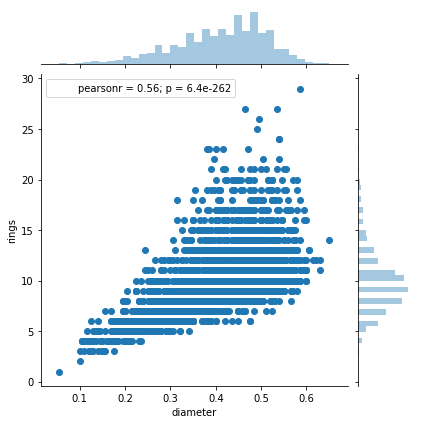

In [309]:
sns.jointplot(train_X['diameter'], train_y)

# Third example
Boston housing get boost using poly features...

In [317]:
from sklearn.datasets import load_boston

In [318]:
data = load_boston()
df = data.data
cols = ['CRIM','ZN','INDUS','CHAS','NOX',
        'RM','AGE','DIS','RAD','TAX',
        'PTRATIO','B','LSTAT']
df = pd.DataFrame(df, columns=cols)
train_X, test_X, train_y, test_y = train_test_split(df, data.target,
                                                    test_size=0.2,
                                                    random_state = 2142018)

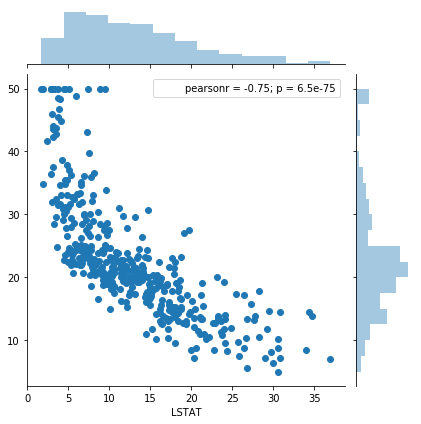

In [319]:
sns.jointplot(train_X['LSTAT'], train_y)

In [320]:
categorical = ['CHAS','RAD']
numeric = ['CRIM','ZN','INDUS','NOX','RM',
        'AGE','DIS','TAX','PTRATIO','B',
        'LSTAT']

In [321]:
mapper = DataFrameMapper(
    [(numeric, PolynomialFeatures(degree=2))] + \
    [(col, OneHotStrings()) for col in categorical])

In [322]:
pipe = Pipeline([
    ('mapper',mapper),
    ('clf', ElasticNetCV(cv=10,
                         l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                         normalize=True))
])

In [323]:
pipe.fit(train_X, train_y)

/Users/benjaminjakubowski/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/benjaminjakubowski/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=True,
        features=[(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT'], PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('CHAS', <__main__.OneHotStrings object at 0x1a2233bfd0>), ('...se,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0))])

In [324]:
pipe.score(train_X, train_y)

0.87936439132693645

In [325]:
pipe.score(test_X, test_y)

0.81638688267707826

In [327]:
mapper2 = DataFrameMapper(
    [(col, None) for col in numeric] + \
    [(col, OneHotStrings()) for col in categorical])

In [328]:
pipe2 = Pipeline([
    ('mapper',mapper2),
    ('clf', ElasticNetCV(cv=10,
                         l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                         normalize=True))
])

In [329]:
pipe2.fit(train_X, train_y)

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('CRIM', None), ('ZN', None), ('INDUS', None), ('NOX', None), ('RM', None), ('AGE', None), ('DIS', None), ('TAX', None), ('PTRATIO', None), ('B', None), ('LSTAT', None), ('CHAS', <__main__.OneHotStrings object at 0x1a22...se,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0))])

In [330]:
pipe2.score(train_X, train_y)

0.76294557728319679

In [331]:
pipe2.score(test_X, test_y)

0.64505494932200413